# DEA Intertidal Elevation validation

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install -r requirements.in --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox

from intertidal.validation import eval_metrics, map_raster, preprocess_validation


def load_reproject(
    path, gbox, name=None, chunks={"x": 2048, "y": 2048}, **reproj_kwargs
):
    """
    Load and reproject part of a raster dataset into a given GeoBox.
    """
    ds = (
        rioxarray.open_rasterio(
            path,
            masked=True,
            chunks=chunks,
        )
        .squeeze("band")
        .odc.reproject(how=gbox, **reproj_kwargs)
        .compute()
    )
    ds.name = name

    return ds

## Load modelled and validation data

### NT LiDAR

In [8]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Load LIDAR validation data
validation_ds = rioxarray.open_rasterio(val_path, masked=True).squeeze("band")
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

### Testing variable threshold - NT

In [6]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path1 = f"data/interim/x99y118/x99y118_2020_2022_elevation.tif"
mod_path2 = f"data/interim/x98y118/x98y118_2020_2022_elevation.tif"
mod_path3 = f"data/interim/x100y117/x100y117_2020_2022_elevation.tif"
# mod_path1 = f"data/interim/x99y118/x99y118_2020_2022_original_elevation.tif"
# mod_path2 = f"data/interim/x98y118/x98y118_2020_2022_original_elevation.tif"
# mod_path3 = f"data/interim/x100y117/x100y117_2020_2022_original_elevation.tif"
resampling = "average"

# Load LIDAR validation data
validation_ds = rioxarray.open_rasterio(val_path, masked=True).squeeze("band")
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds1 = load_reproject(
    path=mod_path1,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds2 = load_reproject(
    path=mod_path2,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds3 = load_reproject(
    path=mod_path3,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds = modelled_ds1.combine_first(modelled_ds2).combine_first(modelled_ds3)


### Moreton Bay SDB

In [ ]:
# Setup
val_path = "data/raw/SDB_AUS_MoretonBay_EOMAP_20220808_20230414_3m_MSL_geotiff.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Set geobox for specific bounding box
bbox = BoundingBox(2050863, -3186980, 2091372, -3070780, crs="EPSG:3577")
bbox = BoundingBox(2054949, -3158856, 2090075, -3130736, crs="EPSG:3577")
gbox = GeoBox.from_bbox(bbox, resolution=10)

# Load SDB as validation data
validation_ds = load_reproject(
    path=val_path, gbox=gbox, name="validation_ds", resampling=resampling
)

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

## Plot layers

In [4]:
# Calculate difference
diff_ds = validation_ds - modelled_ds
diff_ds = diff_ds.odc.assign_crs(modelled_ds.odc.crs)
diff_ds.name = "difference"

# Plot both layers
map_raster(
    [validation_ds, modelled_ds, diff_ds],
    vmin=[-10.0, -10.0, -1.0],
    vmax=[0.5, 0.5, 1.0 ],
    cmap=["viridis", "viridis", "RdBu"],
)

### Validate modelled elevation against validation elevation

Correlation         0.847
RMSE                0.151
MAE                 0.108
R-squared           0.717
Bias               -0.000
Regression slope    0.912
dtype: float64

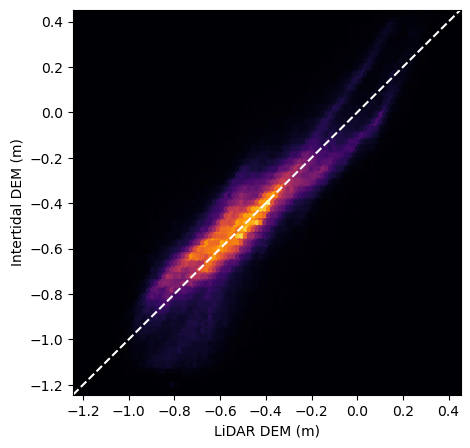

In [10]:
# Preprocess
validation_z, modelled_z = preprocess_validation(modelled_ds, validation_ds, None)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(np.concatenate([validation_z, modelled_z]), [1, 99])
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
eval_metrics(x=validation_z, y=modelled_z, round=3)

### Compare elevation accuracy by uncertainty

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 10.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    
    # Extract subset of modelled elevation according to certainty range
    modelled_ds_subset = modelled_ds.where(
        (uncertainty_ds >= min_thresh) * (uncertainty_ds < max_thresh)
    )

    # Preprocess
    validation_z, modelled_z = preprocess_validation(
        modelled_ds_subset, validation_ds, None
    )

    # Compute accuracy metrics
    certainty_str = f"{min_thresh}-{max_thresh}"
    out[certainty_str] = eval_metrics(
        x=validation_z, y=modelled_z, round=3
    )
    
    # Plot heatmaps
    axes[i].hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(f"Certainty: {certainty_str} m")
    if i == 2:
        axes[i].set_xlabel("LiDAR DEM (m)")
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")

# Combine into a single dataframe
combined_df = pd.concat(out, axis=1)
combined_df.T.plot()
plt.gca().set_title("Accuracy statistics by certainty")
print(combined_df)